### Load data

In [164]:
import os
import multiprocessing.dummy as mp

In [165]:
kalimat_base = "data/KalimatCorpus-2.0"
expected_dirs = os.listdir(kalimat_base)

In [166]:
def check_kalimat_structure_os():
    missing = [d for d in expected_dirs if not os.path.isdir(os.path.join(kalimat_base, d))]
    
    if missing:
        print(f"❌ Missing folders: {missing}")
    else:
        count = 0
        for d in expected_dirs:
            folder_path = os.path.join(kalimat_base, d)
            count += len([f for f in os.listdir(folder_path)])
        print(f"✅ Kalimat Corpus is ready with {count} .txt files")

check_kalimat_structure_os()

✅ Kalimat Corpus is ready with 18256 .txt files


In [167]:
def load_kalimat_articles(category):
    category_path = os.path.join(kalimat_base, category)
    if not os.path.isdir(category_path):
        print(f"❌ Category '{category}' does not exist in the Kalimat Corpus.")
        return []

    articles = []
    for filename in os.listdir(category_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(category_path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                words = [line.strip() for line in f if line.strip()]
                text = " ".join(words)
                articles.append({
                    "category": category.replace("articles", "").upper(),
                    "filename": filename,
                    "text": text,
                    "word_count": len(words)
                })

    print(f"✅ Loaded {len(articles)} articles from category '{category}'")
    return articles

In [168]:
def load_all_articles_parallel():
    with mp.Pool(processes=min(len(expected_dirs), int(os.cpu_count() / 2))) as pool:
        results = pool.map(load_kalimat_articles, expected_dirs)
    
    dataset = [article for category_articles in results for article in category_articles]
    return dataset

In [169]:
if __name__ == "__main__": # To solve the multiprocessing issue on Windows
    dataset = load_all_articles_parallel()
    print(f"✅ Dataset loaded with {len(dataset)} articles.")

✅ Loaded 1689 articles from category 'articlesInternational'
✅ Loaded 2495 articles from category 'articlesCulture'
✅ Loaded 3265 articles from category 'articlesEconomy'
✅ Loaded 3237 articles from category 'articlesLocal'
✅ Loaded 3475 articles from category 'articlesReligion'
✅ Loaded 4095 articles from category 'articlesSports'
✅ Dataset loaded with 18256 articles.


### Preprocessing

In [170]:
import pandas as pd
df = pd.DataFrame(dataset)
df.head(), df['category'].value_counts()

(  category             filename  \
 0  CULTURE     culturecapr1.txt   
 1  CULTURE  culturecapr1005.txt   
 2  CULTURE  culturecapr1006.txt   
 3  CULTURE  culturecapr1007.txt   
 4  CULTURE  culturecapr1008.txt   
 
                                                 text  word_count  
 0  كتب سالم الرحبي : تنطلق اليوم الدورة البرامجية...        2732  
 1  كتب - فيصل العلوي : شاركت السلطنة صباح امس دول...         835  
 2  اربعة عروض على مسرح الشباب وعرض في الرستاق ثم ...         691  
 3  حاوره خالد عبداللطيف : حين يناقش الموضوع الثقا...        1972  
 4  افتتح صباح أمس بقاعة الموسيقي في جامعة السلطان...         329  ,
 category
 SPORTS           4095
 RELIGION         3475
 ECONOMY          3265
 LOCAL            3237
 CULTURE          2495
 INTERNATIONAL    1689
 Name: count, dtype: int64)

In [171]:
import string
import nltk
from nltk.corpus import stopwords
import regex as re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, classification_report
import numpy as np 

In [172]:
nltk.download('stopwords')
nltk.download('punkt')

arabic_stopwords = set(stopwords.words('arabic'))
len(arabic_stopwords)

# we need steeming

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sauda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sauda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


701

In [184]:
def preprocess_text(text):

    stemmer = nltk.stem.ISRIStemmer()

    text = re.sub(r'\p{P}+|\$', '', text)  # remove all punctuation (English + Arabic)
    text = re.sub(r'[0-9٠-٩]', '', text)  # remove Arabic and English digits
    text = re.sub(r'[a-zA-Z]', '', text)  # remove English letters
    text = re.sub(r'[\u064B-\u0652]', '', text)  # remove Arabic diacritics
    text = re.sub(r'\s+', ' ', text).strip()  # clean extra spaces

    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in arabic_stopwords]


    return ' '.join(tokens)

preprocess_text("!مرحباً... هذا نَصٌّ تَجْرِيبِيٌ يحتوي على 123 أرقام ٤٥٦، علامات ترقيم @#$%، كلمات إنجليزية like This.")

'رحب نص جرب حوي رقم علم رقم كلم انجليزية'

In [174]:
df['processed_text'] = df['text'].apply(preprocess_text)

### Visualization

In [175]:
import matplotlib.pyplot as plt
%matplotlib inline

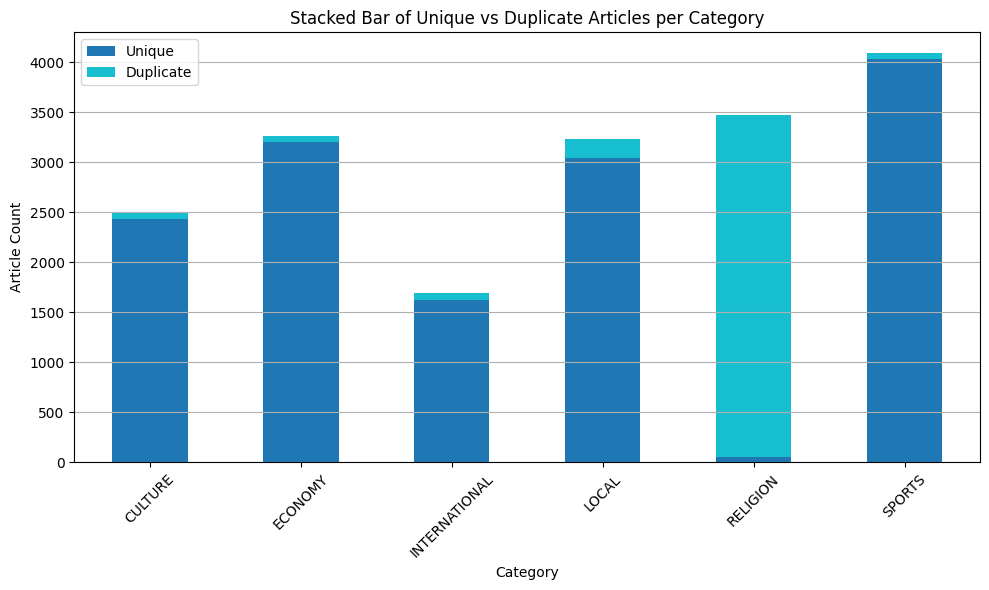

In [176]:
import pandas as pd
import matplotlib.pyplot as plt

df['is_duplicate'] = df.duplicated(subset='processed_text', keep=False)

# Group and make sure both True/False appear
counts = df.groupby(['category', 'is_duplicate']).size().unstack().reindex(columns=[False, True], fill_value=0)
counts.columns = ['Unique', 'Duplicate']

# Plot
counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab10')
plt.title("Stacked Bar of Unique vs Duplicate Articles per Category")
plt.xlabel("Category")
plt.ylabel("Article Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [177]:
df = df.drop_duplicates(subset=['processed_text'])

In [ ]:
vocab = set()
df['processed_text'].str.split().apply(vocab.update)
vocab

In [152]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])

In [153]:

X = tfidf_matrix
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_classifier = RandomForestClassifier(n_estimators=260, random_state=42, n_jobs=-1)


rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
cv_scores = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')

print(f'\nCross-Validation Scores: {cv_scores}')
print(f'Mean Cross-Validation Score: {np.mean(cv_scores):.4f}')

print("\n Model Evaluation")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print("\nClassification Report:")
class_report = classification_report(y_test, y_pred, target_names=sorted(y.unique()))
print(class_report)



Cross-Validation Scores: [0.89184009 0.88085456 0.88934538 0.92056971 0.90632703]
Mean Cross-Validation Score: 0.8978

 Model Evaluation
Accuracy: 0.9167579408543264

Classification Report:
               precision    recall  f1-score   support

      CULTURE       0.91      0.83      0.87       499
      ECONOMY       0.90      0.84      0.87       653
INTERNATIONAL       0.90      0.91      0.91       338
        LOCAL       0.81      0.88      0.84       648
     RELIGION       0.97      1.00      0.99       695
       SPORTS       0.98      0.99      0.99       819

     accuracy                           0.92      3652
    macro avg       0.91      0.91      0.91      3652
 weighted avg       0.92      0.92      0.92      3652



### Tryign with\out duplicates
- without diplicates + no religion :
Mean Cross-Validation Score: 0.8919
accuracy                           0.91      2913
- without diplicates with religion:
Mean Cross-Validation Score: 0.8871
accuracy                           0.90      3025
- with no duplicates with religion:
Mean Cross-Validation Score: 0.8978
accuracy                           0.92      3652
